In [688]:
import pickle
import sys
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('hw2_q2.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data_trn, data_val = data['train'], data['test']
print(data_trn.shape, data_val.shape)

(20000, 32, 32, 3) (6838, 32, 32, 3)


In [754]:
def debug(tensor):
    return tf.check_numerics(tensor, tensor.name)

def pprint(tensor, reshape=False):
#     tensor_to_print = tf.reshape(tensor, [-1, np.prod(tensor.get_shape()[1:])]) if reshape else tensor
    mean, var = tf.nn.moments(tensor, axes=-1)
    
    with tf.control_dependencies([tf.print(tensor.name, " has shape ", 
                                           tf.shape(tensor), "\n", 
                                           "mean: ", mean, 
                                           "var: ", var, "\n", 
#                                            tensor_to_print, 
                                           output_stream=sys.stdout)]):
        return tf.check_numerics(tensor, tensor.name)

In [755]:
def resnet(layer_in, num_channels, output_dim, num_filters=6, num_blocks=2, scope="resnet"):
    
#     TODO: BatchNorm & WeightNormalization
    
    with tf.variable_scope(scope):
        h = conv2d(layer_in, scope="conv2d", kernel=(3, 3), stride=(1, 1), 
                   in_channels=num_channels, out_channels=num_filters)
        
        for idx in range(num_blocks):
            _h = conv2d(h, scope="conv2d_"+str(idx)+"_0", kernel=(1, 1), stride=(1, 1), 
                        in_channels=num_filters, out_channels=num_filters)
            _h = tf.nn.relu(_h)
            _h = conv2d(_h, scope="conv2d_"+str(idx)+"_1", kernel=(3, 3), stride=(1, 1), 
                        in_channels=num_filters, out_channels=num_filters)
            _h = tf.nn.relu(_h)
            _h = conv2d(_h, scope="conv2d_"+str(idx)+"_2", kernel=(1,1), stride=(1, 1), 
                        in_channels=num_filters, out_channels=num_filters)
            h = h + _h
        h = tf.nn.relu(h)
        layer_out = conv2d(h, scope="resnet_layer_out", kernel=(3, 3), stride=(1, 1), 
                           in_channels=num_filters, out_channels=output_dim)
        layer_out = tf.nn.tanh(layer_out)

    return layer_out
        
def conv2d(layer_in, scope, kernel, stride, in_channels, out_channels):
    with tf.variable_scope(scope):
        kernel_h, kernel_w = kernel
        stride_h, stride_w = stride
        weights = tf.get_variable("weights", [kernel_h, kernel_w, in_channels, out_channels], tf.float32)
        layer_out = tf.nn.conv2d(input=layer_in, filter=weights, strides=[1, stride_h, stride_w, 1], 
                                 padding='SAME', name='conv2d_layer_out')

    return layer_out

$$
y=b \odot x+(1-b) \odot(x \odot \exp (s(b \odot x))+t(b \odot x))
$$

In [756]:
class Layer():
    def x2y(self, x, sum_log_jacobian):
        raise NotImplementedError()

    def y2x(self, y):
        raise NotImplementedError()

In [766]:
class CouplingLayer(Layer):
    def __init__(self, scope, mask_type):
        self.scope = scope
        self.mask_type = mask_type
        
    def _get_mask(self, shape):
        if self.mask_type.startswith("checkerboard"):
            if self.mask_type == "checkerboard0":
                mask = tf.constant([[0.0, 1.0], [1.0, 0.0]], dtype=tf.float32)
            elif self.mask_type == "checkerboard1": 
                mask = tf.constant([[1.0, 0.0], [0.0, 1.0]], dtype=tf.float32)
            mask = tf.reshape(mask, [1, 2, 2, 1], name="mask_" + self.mask_type)
            shape = [shape[0], shape[1]//2, shape[2]//2, shape[3]]
            mask = tf.tile(mask, shape)
        elif self.mask_type.startswith("channel"):
            shape = [shape[0], shape[1], shape[2], shape[3]//2]
            ones = tf.ones(shape)
            zeros = tf.zeros(shape)
            if self.mask_type == "channel0":
                mask = tf.concat([ones, zeros], axis=-1, name="mask_" + self.mask_type)
            elif self.mask_type == "channel1": 
                mask = tf.concat([zeros, ones], axis=-1, name="mask_" + self.mask_type)

        return mask
    
    def _build_log_s_t(self, masked_in, scope="_build_log_s_t"):
        num_channels = masked_in.get_shape()[-1]
        with tf.variable_scope(scope):
            resnet_out = resnet(masked_in, num_channels, num_channels * 2)
            log_s, t = tf.split(resnet_out, 2, axis=-1)

        return log_s, t
    
    def x2y(self, x, sum_log_jacobian):
        '''
        sum_log_jacobian = (None,)
        '''
        with tf.variable_scope(self.scope):
            mask = self._get_mask(tf.shape(x))
            masked_x = mask * x
            log_s, t = self._build_log_s_t(masked_x)
            
            y = masked_x + (1 - mask) * (x * tf.exp(log_s) + t)
            sum_log_jacobian += tf.reduce_sum(log_s, axis=[1, 2, 3])
        
        return y, sum_log_jacobian
        
    def y2x(self, y):
        with tf.variable_scope(self.scope, reuse=True):
            mask = self._get_mask(tf.shape(y))
            masked_y = mask * y
            log_s, t = self._build_log_s_t(masked_y)
            x = masked_y + ((1 - mask) * y - t) * tf.exp(-log_s)

        return x

In [767]:
class SqueezingLayer(Layer):
    def __init__(self):
        pass

    def x2y(self, x, sum_log_det_jacobians):
        y = tf.space_to_depth(x, 2)
        return y, sum_log_det_jacobians
    
    def y2x(self, y):
        x = tf.depth_to_space(y, 2)
        return x

In [768]:
class RealNVP():
    def __init__(self, sess, input_shape=(32, 32, 3), learning_rate=1e-5):
        self.sess = sess
        self.x = tf.placeholder(tf.float32, (None,) + input_shape, name="x")
        self._build_layers()
#         self._build_toy_layers()
        self._build_loss()
        self._build_op(learning_rate)
        
        self.z_sample = tf.placeholder(tf.float32, (None,) + self.output_shape, name="z_sample")
        self._build_sample()

    def _build_layers(self):
        self.layers = []
        self.layers.extend([CouplingLayer(
            "0_checkerboard_idx_"+str(idx), "checkerboard" + str(idx % 2)
        ) for idx in range(4)])
        self.layers.append(SqueezingLayer())
        self.layers.extend([CouplingLayer(
            "1_channel_idx_" + str(idx), "channel" + str(idx % 2)
        ) for idx in range(3)])
        self.layers.extend([CouplingLayer(
            "2_checkerboard_idx_"+str(idx), "checkerboard" + str(idx % 2)
        ) for idx in range(3)])
        self.layers.append(SqueezingLayer())
        self.layers.extend([CouplingLayer(
            "3_channel_idx_" + str(idx), "channel" + str(idx % 2)
        ) for idx in range(3)])
        self.layers.extend([CouplingLayer(
            "4_checkerboard_idx_"+str(idx), "checkerboard" + str(idx % 2)
        ) for idx in range(3)])
        
    def _build_toy_layers(self):
        self.layers = [CouplingLayer(
            "0_checkerboard_idx_"+str(idx), "checkerboard" + str(idx % 2)
        ) for idx in range(4)]
        
    def _preprocess(x, alpha=0.05):
        return x, 0
        x = x + np.random.uniform(size=batch.shape)
        x = alpha + (1-alpha) * x/4
        log_jacobian = np.prod(input_shape[1:]) * np.log((1-alpha)/4)
        return x, log_jacobian
        
    def _build_loss(self):
        print("building loss...")
        y, sum_log_jacobian = self.x, 0
        for layer in self.layers:
            y, sum_log_jacobian = layer.x2y(y, sum_log_jacobian)
            sum_log_jacobian = pprint(sum_log_jacobian, True)

        self.output_shape = tuple(y.get_shape()[1:])
        base_dim = np.prod(self.output_shape)
        base_dist = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0] * base_dim, 
            scale_diag=[1.0] * base_dim)
        log_pz = base_dist.log_prob(tf.reshape(y, [-1, base_dim]))
        log_pz = debug(log_pz)
        self.loss = - tf.reduce_mean(log_pz + sum_log_jacobian, axis=0)
        
        # negative log likelihood to bits per dim
        self.loss = self.loss / int(base_dim) + tf.log(4.0)
        self.loss = debug(self.loss)
    
    def _build_op(self, learning_rate, grad_clip=1):
        if grad_clip > 0:
            op = tf.train.AdamOptimizer(learning_rate)
            grads_and_vars = op.compute_gradients(self.loss)
            new_grads_and_vars = [
                (tf.clip_by_value(gv[0], -grad_clip, grad_clip), gv[1]) 
                for gv in grads_and_vars]
            self.op = op.apply_gradients(new_grads_and_vars)
        else:
            self.op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        
    def _build_sample(self):
        print("building samples...")
        y = self.z_sample
        for layer in reversed(self.layers):
            y = layer.y2x(y)
        self.x_sample = y
    
    def step(self, batch, with_update=False):
        if with_update:
            loss, _ = self.sess.run([self.loss, self.op], feed_dict={self.x: batch})
        else:
            loss = self.sess.run(self.loss, feed_dict={self.x: batch})
        return loss
    
    def sample(self, batch):
        return self.sess.run(self.x_sample, feed_dict={self.z_sample: batch})

In [769]:
def train(sess, data_trn, data_val, batch_size=128, num_epochs=10, 
          log_per_epoch=1, print_per_epoch=1):
    print("building model...")
    model = RealNVP(sess)
    init_op = tf.initializers.global_variables()
    sess.run(init_op)
    
    loss_trn = []
    loss_val = []
    
    for epoch in range(num_epochs):
        print("epoch {} starts...".format(epoch))
        loss_trn_batch = []
        for batch in np.array_split(data_trn, np.ceil(len(data_trn)/batch_size)):
            loss = model.step(batch, with_update=True)
            loss_trn_batch.append(loss)

        if epoch % log_per_epoch == 0:
            loss_trn.append(np.mean(loss_trn_batch))
            loss_val.append(model.step(data_val, with_update=False))

        if epoch % print_per_epoch == 0:
            print("at epoch", epoch, loss_trn[-1], loss_val[-1])
            
    return loss_trn, loss_val, model

In [770]:
tf.reset_default_graph()
sess = tf.Session()
loss_trn, loss_val, model = train(sess, data_trn[:1024], data_val[:16])

building model...
building loss...
building samples...
epoch 0 starts...
at epoch 0 223.0865 199.23868
epoch 1 starts...
at epoch 1 179.36868 172.15715
epoch 2 starts...
at epoch 2 145.15915 146.87665
epoch 3 starts...
at epoch 3 118.026375 124.6189
epoch 4 starts...
at epoch 4 95.92245 104.522736
epoch 5 starts...
at epoch 5 77.31355 87.00415
epoch 6 starts...
at epoch 6 62.29827 72.90486
epoch 7 starts...
at epoch 7 50.565323 60.474285
epoch 8 starts...
at epoch 8 41.467194 49.51318
epoch 9 starts...
at epoch 9 34.328903 39.495983


In [772]:
def sample(sess, model, num_samples):
    z = np.random.normal(0.0, 1.0, (num_samples,) + model.output_shape)
    samples = model.sample(z)
    return samples

In [773]:
samples = sample(sess, model, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


55935580000.0 -23841714000.0


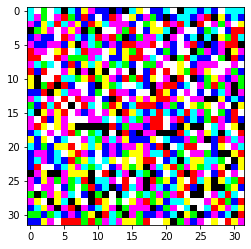

In [765]:
print(max(samples[0].flatten()), min(samples[0].flatten()))
plt.imshow(samples[0]/4)

In [ ]:
# sess.close()